In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers


print(tf.__version__)


import glob
from sklearn import preprocessing

2.1.0


In [4]:
path = r'/home/mayuresh/Solar Paper/LA' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, skiprows=2)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
dataset = frame

In [5]:
dataset

,Year,Month,Day,Hour,Minute,DHI,DNI,GHI,Cloud Type,Dew Point,Solar Zenith Angle,Surface Albedo,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure
0,2017,1,1,0,0,0,0,0,1,3,168.89,0.128,1.8,1.137,309.0,91.39,6,980.0
1,2017,1,1,0,30,0,0,0,1,3,166.73,0.128,2.0,1.230,309.0,91.39,6,980.0
2,2017,1,1,1,0,0,0,0,1,3,162.25,0.128,2.3,1.325,302.1,91.88,6,980.0
3,2017,1,1,1,30,0,0,0,1,3,156.77,0.128,2.4,1.402,302.1,91.88,6,980.0
4,2017,1,1,2,0,0,0,0,1,3,150.87,0.128,2.5,1.479,307.1,92.83,6,980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70075,2014,12,31,21,30,0,0,0,0,3,146.19,0.122,0.9,1.036,17.9,65.24,11,990.0
70076,2014,12,31,22,0,0,0,0,0,3,152.26,0.122,1.0,1.037,28.3,62.52,11,990.0
70077,2014,12,31,22,30,0,0,0,0,3,158.09,0.122,1.1,1.029,28.3,62.51,11,990.0
70078,2014,12,31,23,0,0,0,0,0,2,163.41,0.122,1.2,1.022,37.8,59.05,11,990.0


In [6]:
dataset.pop('DNI')
dataset.pop('DHI')

dataset.pop('Year')
dataset.pop('Month')
dataset.pop('Day')
dataset.pop('Precipitable Water')
dataset.pop('Pressure')
dataset.pop('Minute')

0         0
1        30
2         0
3        30
4         0
         ..
70075    30
70076     0
70077    30
70078     0
70079    30
Name: Minute, Length: 70080, dtype: int64

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [8]:
train_data = preprocessing.normalize(train_dataset)
test_data = preprocessing.normalize(test_dataset)

In [9]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Hour,56064.0,11.500321,6.916577,0.000,6.00,12.000,17.000,23.000
GHI,56064.0,229.229720,314.059799,0.000,0.00,0.000,442.000,1074.000
Cloud Type,56064.0,1.554242,2.447636,0.000,0.00,0.000,3.000,9.000
Dew Point,56064.0,7.995077,5.072151,-14.000,5.00,9.000,11.000,22.000
Solar Zenith Angle,56064.0,89.688433,39.019058,10.670,57.81,89.620,121.840,169.230
Surface Albedo,56064.0,0.132983,0.004045,0.121,0.13,0.134,0.136,0.139
Wind Speed,56064.0,1.974914,1.277014,0.000,1.00,1.600,2.800,10.600
Wind Direction,56064.0,174.363055,97.561239,0.000,77.10,199.600,250.525,360.000
Relative Humidity,56064.0,60.182033,23.732411,6.190,40.95,58.490,80.030,100.000
Temperature,56064.0,18.568814,6.399234,2.000,14.00,18.000,23.000,40.000


In [10]:
train_labels = train_dataset.pop('GHI')
test_labels = test_dataset.pop('GHI')

In [11]:
def norm(x):
 return (x - train_stats['mean']) / train_stats['std']
normed_train_data = preprocessing.normalize(train_dataset)
normed_test_data = preprocessing.normalize(test_dataset)


In [12]:
from tensorflow.keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [13]:
def build_model():
  model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01),  input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(1, kernel_regularizer=regularizers.l2(0.01)),
])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae','mse', r2_keras])
  return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2560      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 45,825
Trainable params: 45,825
Non-trainable params: 0
_________________________________________________________________


In [15]:
EPOCHS = 500

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2,verbose=True)

Train on 44851 samples, validate on 11213 samples
Epoch 1/500
44851/44851 [==============================] - 34s 759us/sample - loss: 13072.5506 - mae: 58.0409 - mse: 13069.6631 - r2_keras: 0.8609 - val_loss: 6004.4914 - val_mae: 42.9543 - val_mse: 6001.3354 - val_r2_keras: 0.9334
Epoch 2/500
44851/44851 [==============================] - 30s 661us/sample - loss: 4342.4855 - mae: 32.2514 - mse: 4339.1841 - r2_keras: 0.9512 - val_loss: 3853.1441 - val_mae: 30.2251 - val_mse: 3849.6753 - val_r2_keras: 0.9567
Epoch 3/500
44851/44851 [==============================] - 32s 721us/sample - loss: 3555.6092 - mae: 28.9268 - mse: 3551.9968 - r2_keras: 0.9604 - val_loss: 3047.7071 - val_mae: 24.9313 - val_mse: 3043.9600 - val_r2_keras: 0.9652
Epoch 4/500
44851/44851 [==============================] - 34s 759us/sample - loss: 3210.1768 - mae: 27.4530 - mse: 3206.3020 - r2_keras: 0.9642 - val_loss: 3549.5431 - val_mae: 30.8192 - val_mse: 3545.5349 - val_r2_keras: 0.9600
Epoch 5/500
44851/44851 [===

44851/44851 [==============================] - 23s 505us/sample - loss: 2279.8895 - mae: 21.1842 - mse: 2273.1782 - r2_keras: 0.9746 - val_loss: 2279.3761 - val_mae: 19.5855 - val_mse: 2272.6294 - val_r2_keras: 0.9737
Epoch 37/500
44851/44851 [==============================] - 24s 543us/sample - loss: 2267.0372 - mae: 21.0815 - mse: 2260.2351 - r2_keras: 0.9748 - val_loss: 2389.8975 - val_mae: 20.7022 - val_mse: 2383.0398 - val_r2_keras: 0.9726
Epoch 38/500
44851/44851 [==============================] - 24s 527us/sample - loss: 2276.5152 - mae: 21.2426 - mse: 2269.6208 - r2_keras: 0.9746 - val_loss: 2452.4247 - val_mae: 21.4060 - val_mse: 2445.4775 - val_r2_keras: 0.9721
Epoch 39/500
44851/44851 [==============================] - 23s 523us/sample - loss: 2247.0783 - mae: 21.0170 - mse: 2240.0869 - r2_keras: 0.9751 - val_loss: 2425.5516 - val_mae: 21.3146 - val_mse: 2418.5029 - val_r2_keras: 0.9725
Epoch 40/500
44851/44851 [==============================] - 23s 521us/sample - loss: 2282

44851/44851 [==============================] - 21s 478us/sample - loss: 2089.8797 - mae: 19.7031 - mse: 2079.3826 - r2_keras: 0.9768 - val_loss: 2266.5432 - val_mae: 19.0290 - val_mse: 2255.9995 - val_r2_keras: 0.9738
Epoch 72/500
44851/44851 [==============================] - 20s 450us/sample - loss: 2082.1314 - mae: 19.6789 - mse: 2071.5156 - r2_keras: 0.9767 - val_loss: 2259.5601 - val_mae: 19.4770 - val_mse: 2248.8801 - val_r2_keras: 0.9742
Epoch 73/500
44851/44851 [==============================] - 19s 415us/sample - loss: 2100.1667 - mae: 19.9556 - mse: 2089.4053 - r2_keras: 0.9766 - val_loss: 2491.7990 - val_mae: 22.9907 - val_mse: 2480.9482 - val_r2_keras: 0.9717
Epoch 74/500
44851/44851 [==============================] - 20s 443us/sample - loss: 2064.1219 - mae: 19.6653 - mse: 2053.2292 - r2_keras: 0.9769 - val_loss: 2390.0882 - val_mae: 21.4013 - val_mse: 2379.1494 - val_r2_keras: 0.9729
Epoch 75/500
44851/44851 [==============================] - 19s 434us/sample - loss: 2074

44851/44851 [==============================] - 17s 372us/sample - loss: 1922.5568 - mae: 18.7357 - mse: 1908.0802 - r2_keras: 0.9785 - val_loss: 2619.7072 - val_mae: 24.6029 - val_mse: 2605.1602 - val_r2_keras: 0.9703
Epoch 107/500
44851/44851 [==============================] - 16s 368us/sample - loss: 1965.9893 - mae: 19.0782 - mse: 1951.3854 - r2_keras: 0.9782 - val_loss: 2338.9673 - val_mae: 20.9088 - val_mse: 2324.2959 - val_r2_keras: 0.9734
Epoch 108/500
44851/44851 [==============================] - 20s 455us/sample - loss: 1953.2090 - mae: 19.0339 - mse: 1938.4852 - r2_keras: 0.9784 - val_loss: 2229.1908 - val_mae: 18.9180 - val_mse: 2214.3901 - val_r2_keras: 0.9745
Epoch 109/500
44851/44851 [==============================] - 20s 450us/sample - loss: 1948.0270 - mae: 18.9735 - mse: 1933.1503 - r2_keras: 0.9783 - val_loss: 2232.0589 - val_mae: 18.6985 - val_mse: 2217.1108 - val_r2_keras: 0.9743
Epoch 110/500
44851/44851 [==============================] - 19s 417us/sample - loss: 

44851/44851 [==============================] - 20s 456us/sample - loss: 1863.9253 - mae: 18.4475 - mse: 1845.1281 - r2_keras: 0.9795 - val_loss: 2352.3453 - val_mae: 21.2838 - val_mse: 2333.5085 - val_r2_keras: 0.9733
Epoch 142/500
44851/44851 [==============================] - 27s 611us/sample - loss: 1840.8523 - mae: 18.3198 - mse: 1821.9498 - r2_keras: 0.9798 - val_loss: 2254.4327 - val_mae: 19.5504 - val_mse: 2235.4800 - val_r2_keras: 0.9743
Epoch 143/500
44851/44851 [==============================] - 20s 439us/sample - loss: 1874.7093 - mae: 18.5526 - mse: 1855.6991 - r2_keras: 0.9793 - val_loss: 2237.0952 - val_mae: 19.7656 - val_mse: 2218.0447 - val_r2_keras: 0.9745
Epoch 144/500
44851/44851 [==============================] - 18s 407us/sample - loss: 1847.7852 - mae: 18.3763 - mse: 1828.6797 - r2_keras: 0.9795 - val_loss: 2156.4752 - val_mae: 18.3919 - val_mse: 2137.3118 - val_r2_keras: 0.9756
Epoch 145/500
44851/44851 [==============================] - 20s 437us/sample - loss: 

44851/44851 [==============================] - 16s 367us/sample - loss: 1747.8761 - mae: 17.8335 - mse: 1725.2433 - r2_keras: 0.9807 - val_loss: 2316.7522 - val_mae: 19.6944 - val_mse: 2294.0718 - val_r2_keras: 0.9735
Epoch 177/500
44851/44851 [==============================] - 16s 356us/sample - loss: 1757.1309 - mae: 17.8637 - mse: 1734.3989 - r2_keras: 0.9806 - val_loss: 2288.3810 - val_mae: 20.3142 - val_mse: 2265.5803 - val_r2_keras: 0.9743
Epoch 178/500
44851/44851 [==============================] - 16s 366us/sample - loss: 1766.7434 - mae: 17.9687 - mse: 1743.8898 - r2_keras: 0.9806 - val_loss: 2294.6333 - val_mae: 18.7930 - val_mse: 2271.7422 - val_r2_keras: 0.9739
Epoch 179/500
44851/44851 [==============================] - 19s 418us/sample - loss: 1742.1499 - mae: 17.7705 - mse: 1719.2036 - r2_keras: 0.9807 - val_loss: 2369.0218 - val_mae: 19.9729 - val_mse: 2346.0168 - val_r2_keras: 0.9735
Epoch 180/500
44851/44851 [==============================] - 20s 447us/sample - loss: 

44851/44851 [==============================] - 19s 413us/sample - loss: 1707.7568 - mae: 17.5314 - mse: 1681.3729 - r2_keras: 0.9812 - val_loss: 2234.7153 - val_mae: 18.6694 - val_mse: 2208.2761 - val_r2_keras: 0.9746
Epoch 212/500
44851/44851 [==============================] - 17s 385us/sample - loss: 1649.4246 - mae: 17.2772 - mse: 1622.9059 - r2_keras: 0.9821 - val_loss: 2280.2268 - val_mae: 18.7491 - val_mse: 2253.6692 - val_r2_keras: 0.9744
Epoch 213/500
44851/44851 [==============================] - 17s 379us/sample - loss: 1665.6856 - mae: 17.2988 - mse: 1639.0669 - r2_keras: 0.9818 - val_loss: 2390.9034 - val_mae: 20.5010 - val_mse: 2364.2163 - val_r2_keras: 0.9733
Epoch 214/500
44851/44851 [==============================] - 19s 421us/sample - loss: 1661.4819 - mae: 17.3772 - mse: 1634.7483 - r2_keras: 0.9819 - val_loss: 2209.9218 - val_mae: 18.5196 - val_mse: 2183.1189 - val_r2_keras: 0.9748
Epoch 215/500
44851/44851 [==============================] - 21s 468us/sample - loss: 

44851/44851 [==============================] - 19s 414us/sample - loss: 1610.4851 - mae: 17.0717 - mse: 1580.4078 - r2_keras: 0.9825 - val_loss: 2744.0829 - val_mae: 24.8223 - val_mse: 2713.9424 - val_r2_keras: 0.9690
Epoch 247/500
44851/44851 [==============================] - 21s 459us/sample - loss: 1614.1333 - mae: 17.1759 - mse: 1583.9459 - r2_keras: 0.9823 - val_loss: 2222.8660 - val_mae: 18.5036 - val_mse: 2192.6270 - val_r2_keras: 0.9752
Epoch 248/500
44851/44851 [==============================] - 19s 428us/sample - loss: 1570.9774 - mae: 16.8521 - mse: 1540.6599 - r2_keras: 0.9823 - val_loss: 2283.6191 - val_mae: 18.9505 - val_mse: 2253.2297 - val_r2_keras: 0.9741
Epoch 249/500
44851/44851 [==============================] - 20s 437us/sample - loss: 1561.6292 - mae: 16.8953 - mse: 1531.2000 - r2_keras: 0.9829 - val_loss: 2293.5026 - val_mae: 18.7427 - val_mse: 2263.0356 - val_r2_keras: 0.9742
Epoch 250/500
44851/44851 [==============================] - 21s 459us/sample - loss: 

44851/44851 [==============================] - 19s 424us/sample - loss: 1521.2332 - mae: 16.7175 - mse: 1487.4827 - r2_keras: 0.9836 - val_loss: 2284.6084 - val_mae: 18.6559 - val_mse: 2250.8235 - val_r2_keras: 0.9744
Epoch 282/500
44851/44851 [==============================] - 19s 424us/sample - loss: 1494.7308 - mae: 16.5008 - mse: 1460.9155 - r2_keras: 0.9835 - val_loss: 2558.9624 - val_mae: 22.3310 - val_mse: 2525.1045 - val_r2_keras: 0.9714
Epoch 283/500
44851/44851 [==============================] - 17s 381us/sample - loss: 1505.6507 - mae: 16.7164 - mse: 1471.7323 - r2_keras: 0.9836 - val_loss: 2495.8763 - val_mae: 22.6053 - val_mse: 2461.8928 - val_r2_keras: 0.9721
Epoch 284/500
44851/44851 [==============================] - 18s 406us/sample - loss: 1507.0920 - mae: 16.5263 - mse: 1473.0577 - r2_keras: 0.9835 - val_loss: 2463.9842 - val_mae: 20.2162 - val_mse: 2429.8965 - val_r2_keras: 0.9726
Epoch 285/500
44851/44851 [==============================] - 19s 422us/sample - loss: 

44851/44851 [==============================] - 29s 637us/sample - loss: 1445.8093 - mae: 16.3040 - mse: 1408.6659 - r2_keras: 0.9841 - val_loss: 2278.0109 - val_mae: 19.2717 - val_mse: 2240.8325 - val_r2_keras: 0.9743
Epoch 317/500
44851/44851 [==============================] - 28s 624us/sample - loss: 1428.3000 - mae: 16.1410 - mse: 1391.0745 - r2_keras: 0.9845 - val_loss: 2277.3679 - val_mae: 19.0051 - val_mse: 2240.0869 - val_r2_keras: 0.9743
Epoch 318/500
44851/44851 [==============================] - 25s 551us/sample - loss: 1446.8922 - mae: 16.3054 - mse: 1409.5488 - r2_keras: 0.9842 - val_loss: 2240.7935 - val_mae: 19.5664 - val_mse: 2203.4128 - val_r2_keras: 0.9750
Epoch 319/500
44851/44851 [==============================] - 25s 559us/sample - loss: 1422.7648 - mae: 16.0930 - mse: 1385.3243 - r2_keras: 0.9846 - val_loss: 2284.4126 - val_mae: 18.9444 - val_mse: 2246.9358 - val_r2_keras: 0.9743
Epoch 320/500
44851/44851 [==============================] - 23s 521us/sample - loss: 

44851/44851 [==============================] - 26s 576us/sample - loss: 1391.6626 - mae: 15.9645 - mse: 1351.3309 - r2_keras: 0.9847 - val_loss: 2251.1009 - val_mae: 18.8663 - val_mse: 2210.7502 - val_r2_keras: 0.9748
Epoch 352/500
44851/44851 [==============================] - 26s 581us/sample - loss: 1397.9824 - mae: 16.0186 - mse: 1357.5607 - r2_keras: 0.9849 - val_loss: 2232.7725 - val_mae: 18.8531 - val_mse: 2192.3169 - val_r2_keras: 0.9751
Epoch 353/500
44851/44851 [==============================] - 24s 529us/sample - loss: 1375.2853 - mae: 15.8724 - mse: 1334.7916 - r2_keras: 0.9852 - val_loss: 2326.4138 - val_mae: 18.9008 - val_mse: 2285.8669 - val_r2_keras: 0.9738
Epoch 354/500
44851/44851 [==============================] - 23s 520us/sample - loss: 1380.9642 - mae: 15.9388 - mse: 1340.3811 - r2_keras: 0.9850 - val_loss: 2287.8563 - val_mae: 18.6986 - val_mse: 2247.2390 - val_r2_keras: 0.9743
Epoch 355/500
44851/44851 [==============================] - 30s 660us/sample - loss: 

44851/44851 [==============================] - 18s 412us/sample - loss: 1334.6452 - mae: 15.6016 - mse: 1291.1633 - r2_keras: 0.9855 - val_loss: 2251.4887 - val_mae: 18.1943 - val_mse: 2207.9934 - val_r2_keras: 0.9747
Epoch 387/500
44851/44851 [==============================] - 16s 365us/sample - loss: 1342.1034 - mae: 15.7046 - mse: 1298.5685 - r2_keras: 0.9855 - val_loss: 2367.0314 - val_mae: 19.2949 - val_mse: 2323.4583 - val_r2_keras: 0.9738
Epoch 388/500
44851/44851 [==============================] - 16s 367us/sample - loss: 1345.3969 - mae: 15.7141 - mse: 1301.7711 - r2_keras: 0.9856 - val_loss: 2304.6370 - val_mae: 18.2068 - val_mse: 2260.9365 - val_r2_keras: 0.9740
Epoch 389/500
44851/44851 [==============================] - 19s 427us/sample - loss: 1328.6546 - mae: 15.5786 - mse: 1284.9307 - r2_keras: 0.9856 - val_loss: 2268.9743 - val_mae: 17.9328 - val_mse: 2225.2256 - val_r2_keras: 0.9745
Epoch 390/500
44851/44851 [==============================] - 23s 523us/sample - loss: 

44851/44851 [==============================] - 18s 392us/sample - loss: 1269.1146 - mae: 15.3000 - mse: 1222.6140 - r2_keras: 0.9859 - val_loss: 2349.6253 - val_mae: 19.4670 - val_mse: 2303.0923 - val_r2_keras: 0.9737
Epoch 422/500
44851/44851 [==============================] - 15s 335us/sample - loss: 1270.2825 - mae: 15.1572 - mse: 1223.6876 - r2_keras: 0.9862 - val_loss: 2322.3181 - val_mae: 18.4050 - val_mse: 2275.7007 - val_r2_keras: 0.9740
Epoch 423/500
44851/44851 [==============================] - 16s 361us/sample - loss: 1248.5479 - mae: 15.2763 - mse: 1201.8772 - r2_keras: 0.9867 - val_loss: 2323.8078 - val_mae: 19.4916 - val_mse: 2277.0847 - val_r2_keras: 0.9743
Epoch 424/500
44851/44851 [==============================] - 17s 368us/sample - loss: 1272.7679 - mae: 15.3560 - mse: 1226.0033 - r2_keras: 0.9862 - val_loss: 2286.8673 - val_mae: 18.4836 - val_mse: 2240.0862 - val_r2_keras: 0.9746
Epoch 425/500
44851/44851 [==============================] - 16s 353us/sample - loss: 

44851/44851 [==============================] - 25s 554us/sample - loss: 1246.6746 - mae: 15.0833 - mse: 1197.1757 - r2_keras: 0.9868 - val_loss: 2275.7477 - val_mae: 18.2207 - val_mse: 2226.2437 - val_r2_keras: 0.9747
Epoch 457/500
44851/44851 [==============================] - 24s 545us/sample - loss: 1206.5961 - mae: 14.8166 - mse: 1157.0538 - r2_keras: 0.9871 - val_loss: 2448.9151 - val_mae: 20.7124 - val_mse: 2399.3037 - val_r2_keras: 0.9728
Epoch 458/500
44851/44851 [==============================] - 25s 559us/sample - loss: 1204.2770 - mae: 14.8396 - mse: 1154.6465 - r2_keras: 0.9871 - val_loss: 2323.1242 - val_mae: 18.6088 - val_mse: 2273.4446 - val_r2_keras: 0.9744
Epoch 459/500
44851/44851 [==============================] - 24s 539us/sample - loss: 1210.1763 - mae: 15.0000 - mse: 1160.4729 - r2_keras: 0.9869 - val_loss: 2258.3305 - val_mae: 17.9117 - val_mse: 2208.5801 - val_r2_keras: 0.9751
Epoch 460/500
44851/44851 [==============================] - 25s 547us/sample - loss: 

44851/44851 [==============================] - 25s 567us/sample - loss: 1180.5598 - mae: 14.8236 - mse: 1128.2551 - r2_keras: 0.9875 - val_loss: 2470.5820 - val_mae: 19.8661 - val_mse: 2418.2358 - val_r2_keras: 0.9726
Epoch 492/500
44851/44851 [==============================] - 25s 567us/sample - loss: 1184.9649 - mae: 14.9334 - mse: 1132.6021 - r2_keras: 0.9874 - val_loss: 2385.4995 - val_mae: 18.8532 - val_mse: 2333.1165 - val_r2_keras: 0.9737
Epoch 493/500
44851/44851 [==============================] - 25s 553us/sample - loss: 1218.5322 - mae: 15.1037 - mse: 1166.0992 - r2_keras: 0.9869 - val_loss: 2257.0804 - val_mae: 17.9310 - val_mse: 2204.6113 - val_r2_keras: 0.9750
Epoch 494/500
44851/44851 [==============================] - 24s 534us/sample - loss: 1180.8203 - mae: 14.8148 - mse: 1128.3083 - r2_keras: 0.9873 - val_loss: 2255.1955 - val_mae: 18.3703 - val_mse: 2202.6279 - val_r2_keras: 0.9753
Epoch 495/500
44851/44851 [==============================] - 25s 548us/sample - loss: 

In [13]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Using TensorFlow backend.


Saved model to disk


In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

model.evaluate(test_dataset, test_labels)
print(test_labels)
y_pred = model.predict(test_dataset)
rmse = mean_squared_error(test_labels,y_pred)
print(rmse)

14016/14016 [==============================] - 3s 210us/sample - loss: 2332.0211 - mae: 22.8413 - mse: 2279.0342 - r2_keras: 0.9654
5          0
10         0
13         0
21       510
26       539
        ... 
70053    515
70058    544
70063    209
70064    123
70067      0
Name: GHI, Length: 14016, dtype: int64
2279.035075614549


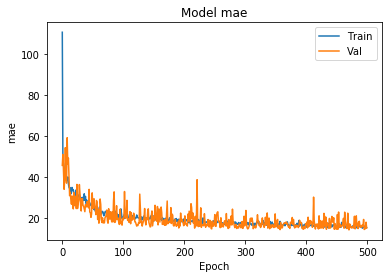

In [20]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mae')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('mae1')
plt.show()


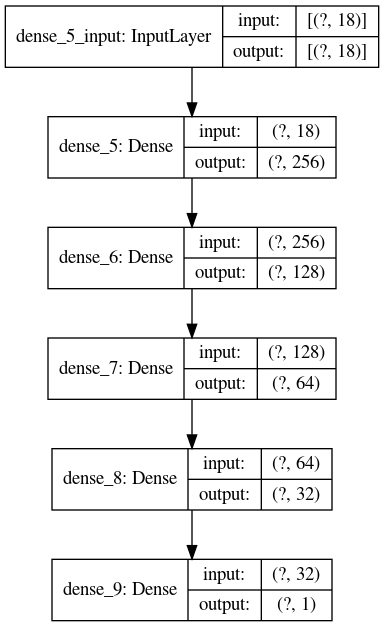

In [15]:
from keras.utils import plot_model
import pydot
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)